# R68 MCMC_faster

Use MCMC to estimate yield model parameters for R68 data.
This is a redesigned version of the R68_MCMC notebook.
It is an effort to streamline the calculations and keep better track of settings used in each mcmc fit.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Set up notebook and load some R68 constants (V, eps, etc.)
exec(open("nb_setup.py").read())#Is there a better way to do this?
from constants import *

#TESTING
import os
os.environ["OMP_NUM_THREADS"] = "1"

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles


Construct a dictionary to store all the MCMC fit parameters and results

In [2]:
mcmc_data={'g4_load_frac':0.1,
          'cap_load_frac':0.1,
          'cap_sim_file':'/data/chocula/villaa/cascadeSimData/si28_R68_400k.pkl',
          'cap_rcapture':0.161,
          'Emax':None,
          'Ebins':None,
           #'Ymodel':'Sor',
           'likelihood':'Pois',
           'doDetRes': True,
           'fpeak':1.0
          }

In [3]:
mcmc_data

{'g4_load_frac': 0.1,
 'cap_load_frac': 0.1,
 'cap_sim_file': '/data/chocula/villaa/cascadeSimData/si28_R68_400k.pkl',
 'cap_rcapture': 0.161,
 'Emax': None,
 'Ebins': None,
 'likelihood': 'Pois',
 'doDetRes': True,
 'fpeak': 1.0}

In [4]:
#Load the datasets
import R68_load as r68

meas=r68.load_measured()
g4=r68.load_G4(load_frac=mcmc_data['g4_load_frac'])
cap=r68.load_simcap(file=mcmc_data['cap_sim_file'], rcapture=mcmc_data['cap_rcapture'], load_frac=mcmc_data['cap_load_frac'])

#Import yield models
import R68_yield as Yield
import R68_spec_tools as spec

Y=Yield.Yield('Lind',[0.15])
print(Y.models)

Loading Measured Data...
(480634,)
(174510,)
Loading Geant4 Data...
(528848, 7)
(129555, 7)
Loading NRs...


KeyboardInterrupt: 

In [4]:
#Set eVee energy binning
Emax = 2000 #eVee
Ebins=np.linspace(0,Emax,201)
mcmc_data['Emax']=Emax
mcmc_data['Ebins']=Ebins


#Measured spectra
N_meas_PuBe,_ = np.histogram(meas['PuBe']['E'],bins=Ebins)
N_meas_Bkg,_ = np.histogram(meas['Bkg']['E'],bins=Ebins)

tlive_PuBe = meas['PuBe']['tlive']
tlive_Bkg = meas['Bkg']['tlive']
#We'll scale everything to the PuBe live time and work with counts, not rate, to get the Poisson stats right

N_meas_Bkg_scaled = N_meas_Bkg * tlive_PuBe/tlive_Bkg
#Estimate of counts due to PuBe
N_meas = N_meas_PuBe - N_meas_Bkg_scaled


#g4 Simulations
#Trim events that won't figure into the analysis range
#Trimmed sim data
Eee_er=np.sum(g4['ER']['E'],axis=1)
Evec_er_cut=(Eee_er>10) & (Eee_er<3e3)
Evec_er=g4['ER']['E'][Evec_er_cut]

Eee_nr=np.sum(g4['NR']['E'],axis=1)
Evec_nr_cut=(Eee_nr>10) & (Eee_nr<30e3)
Evec_nr=g4['NR']['E'][Evec_nr_cut]

#Simulated ER spectrum
N_er = spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_er, Yield=1.0, F=F, scale=1, 
                                   doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'])                                                             

In [5]:
#Define likelihood functions
from scipy.special import factorial, gamma, loggamma

#Poisson likelihood of measuring k given expected mean of lambda
def pois_likelihood(k, lamb):
    return (lamb**k)*np.exp(-lamb)/gamma(k+1.)

#Poisson log-likelihood
#k: observed counts
#lamb: expected (model) counts
def ll_pois(k, lamb):   
    if np.sum(lamb<=0):
        return -np.inf
    
    return np.sum(k*np.log(lamb) - lamb - loggamma(k+1.))

#Normal log-likelihood, limit of Poisson for large lambda
#k: observed counts
#lamb: expected (model) counts
def ll_norm(k,lamb):
    if np.sum(lamb<=0):
        return -np.inf
    
    return np.sum(-0.5*np.log(2*np.pi*lamb) - (k-lamb)**2/(2*lamb))

#Log of flat prior functions
#theta: array of parameter values
#bounds: array of parameter bounds. shape should be len(theta)x2
def lp_flat(theta, bounds):
    #for itheta,ibounds in zip(theta,bounds):
    #    if not (ibounds[0] < itheta < ibounds[1]):
    #        return -np.inf
        
    #return 0.0
    
    if (np.array(bounds)[:,0]<theta).all() and (theta<np.array(bounds)[:,1]).all():
        return 0.0
    return -np.inf

#Log of normal prior distribution
#theta: parameter value(s)
#mu: parameter prior distribution mean(s)
#sigma: paramter prior distribution sigma(s)
def lp_norm(theta, mu, sigma):
    return np.sum(-0.5*((theta-mu)/sigma)**2 - np.log(sigma)-0.5*np.log(2*np.pi))

Construct the probability function. This contains much of the meat of this calculation.
It takes our model parameters and returns the resulting probability

In [6]:
#Calculate Log probability, log(likelihood*prior)
#
#theta: array of fit parameters (yield_par0, yield_par1, ...,  F_NR, scale_g4, scale_ng, ...)
#theta_bounds: paramter bounds, shape should be len(theta)x2
#spec_bounds: range of bin numbers in spectrum to consider. The analysis range is [bin_low,bin_high)
#likelihood: Likelihood function, either 'Pois' or 'Norm'

def calc_log_prob(theta=[0.2, 1, 1, 1], theta_bounds=((0,1),(0,10),(0,10),(0,10)), spec_bounds=(5,101),
                  likelihood='Pois'):

    #Access the global data
    #These must be already defined!!!
    global N_meas, N_er, tlive_PuBe, Evec_nr, cap, Y
    
    ############
    #Set some local variables
    nYpar=Y.npars

    Y.set_pars(theta[:nYpar])
    F_NR=theta[nYpar]
    scale_g4=theta[nYpar+1]
    scale_ng=theta[nYpar+2]
    
    
    #Calculate the (log)prior first since we may not need to calculate the likelihood
    lp=lp_flat(theta, theta_bounds)
    if not np.isfinite(lp):
        return -np.inf
        
    
    ##########
    #Build the spectra

    #NR
    N_nr=spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_nr, Yield=Y, F=F_NR, scale=1, 
                                               doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'])
    #(n,gamma)
    N_ng=spec.buildAvgSimSpectrum_ee_composite(Ebins=Ebins, Evec=cap['E'], dEvec=cap['dE'], Yield=Y, F=F_NR, scale=1, 
                                               doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'])
    

    #Total counts for PuBe live time
    #Uncertainty will be ~sqrt(N)
    N_pred = (N_nr*scale_g4/g4['NR']['tlive'] + N_er*scale_g4/g4['ER']['tlive'] + N_ng*scale_ng/cap['tlive'])*tlive_PuBe

    ##########
    #Calculate the log probability = log prior + log likelihood
    ll=None
    
    if likelihood=='Norm':
        ll = ll_norm(N_meas[slice(*spec_bounds)],N_pred[slice(*spec_bounds)])
    elif likelihood=='Pois':
        ll = ll_pois(N_meas[slice(*spec_bounds)],N_pred[slice(*spec_bounds)])
    else:
        print('Error: Bad likelihood')
        return None
    
    if not np.isfinite(ll):
        return -np.inf
    
    return lp + ll

# Sorenson Fit

In [8]:
import emcee
from multiprocessing import Pool

#Sorenson fit

Y=Yield.Yield('Sor',[0.2,2e-3])
mcmc_data['Ymodel']='Sor'

labels = [r'k', r'q', r'$F_{NR}$', r'$scale_{G4}$', r'$scale_{ng}$']
mcmc_data['labels']=labels

theta_bounds=((0,1),(0,3e-2),(0,50),(0,10),(0,10))
mcmc_data['theta_bounds']=theta_bounds
#Wrapper help

#Test full range fit
E_lim_min=50 #eVee
E_lim_max=1.75e3 #eVee
spec_bounds=(np.digitize(E_lim_min,Ebins)-1,np.digitize(E_lim_max,Ebins)-1)
mcmc_data['spec_bounds']=spec_bounds

def SorFit_helper(theta):                 
    return calc_log_prob(theta=theta, theta_bounds=theta_bounds,
                         spec_bounds=spec_bounds, likelihood=mcmc_data['likelihood'])

In [ ]:
import time

nwalkers=16
ndim=5
nstep=5

mcmc_data['nwalkers'] = nwalkers
mcmc_data['ndim'] = ndim
mcmc_data['nstep'] = nstep

#guesses_s = np.array([0.18, 2e-3, 3.0, 1.0, 1.0]) + np.array([1e-2, 1e-4, 1, 0.1, 0.1]) * np.random.randn(nwalkers_s, ndim_s)

#Sample priors uniformly
mcmc_data['guesses']=(np.array(theta_bounds)[:,1]-np.array(theta_bounds)[:,0])*np.random.random_sample((nwalkers, ndim))+np.array(theta_bounds)[:,0]

with Pool(processes=20) as pool: #Can fail depending on current memory usage of other processes...
    sampler = emcee.EnsembleSampler(nwalkers, ndim, SorFit_helper, pool=pool)
    start = time.time()
    sampler.run_mcmc(mcmc_data['guesses'], nstep, progress=True);
    end = time.time()
    mcmc_data['t_run']=end - start

In [9]:
#Save this work
import pickle as pkl
import os

saveMCMC=True

if saveMCMC:
    ifile = 0
    fname='data/mcmc_Sor_{0}walk_{1}step_pois_v{2}.pkl'.format(nwalkers,nstep,ifile+1)
    while os.path.exists(fname):
        ifile += 1
        fname='data/mcmc_Sor_{0}walk_{1}step_pois_v{2}.pkl'.format(nwalkers,nstep,ifile+1)
        
    print(fname)
    saveFile = open(fname, 'wb')
    
    mcmc_data['sampler']=sampler
    
    pkl.dump(mcmc_data,saveFile)
    saveFile.close()

data/mcmc_Sor_16walk_5000step_pois_v12.pkl


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


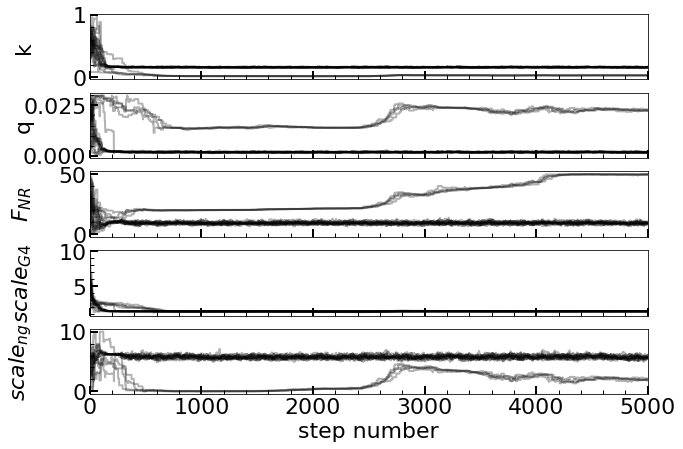

In [10]:
#Look at the chain of parameter values
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    #ax.set_ylim(0, 5)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [11]:
#Get the sample autocorrelation time
tau=sampler.get_autocorr_time()
print(tau)
avgtau=round(np.average(tau))
print(avgtau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [149.89301075 288.94810788 437.03156833 172.03787443 247.08800752]

In [12]:
#Discard a few times tau as burn-in and thin by tau/2
avgtau=100
flat_samples = sampler.get_chain(discard=int(2.*avgtau), thin=int(round(avgtau/2.)), flat=True)
print(flat_samples.shape)

(1536, 5)


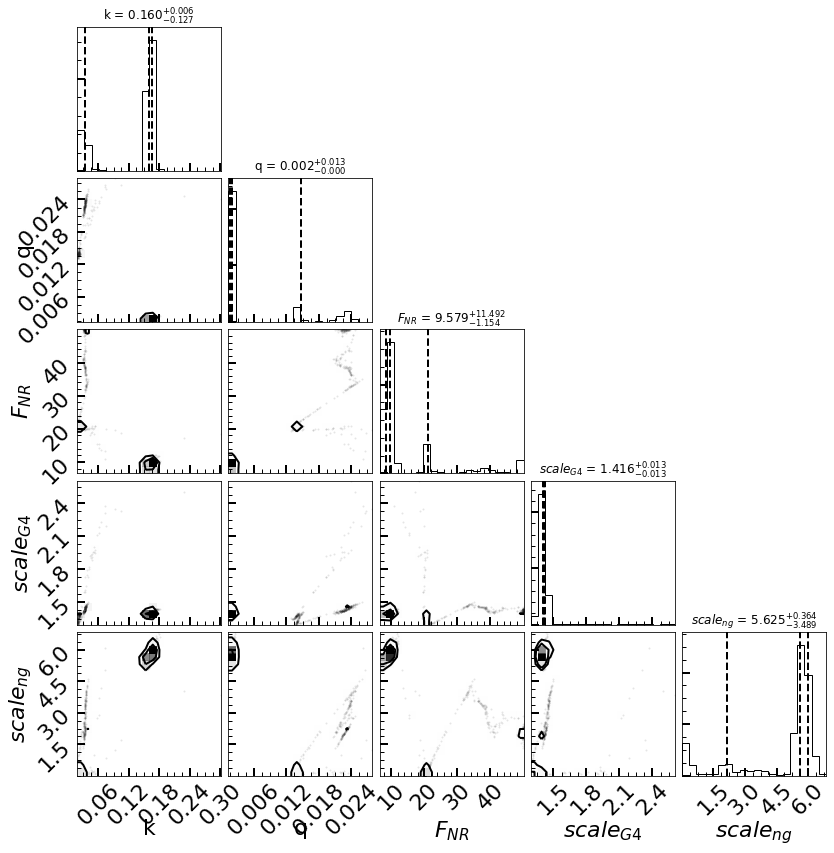

In [13]:
import corner
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='0.3f');